In [2]:
# --- Setup & Imports ---
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from src.io.paths import PathsConfig, ensure_output_structure
from src.io.data import load_datasets
from src.synthetic.enrich import enrich_imn_with_poi
from src.synthetic.stays import read_stays_from_trips, extract_stays_by_day
from src.synthetic.timelines import build_stay_distributions, prepare_day_data
from src.visualization.timelines import save_user_timelines, _visualize_day_data
from src.visualization.reports import user_probs_report

# --- Configuration ---
paths = PathsConfig(
    full_imn_path='data/milano_2007_imns.json.gz',
    test_imn_path='data/test_milano_imns.json.gz',
    poi_path='data/test_milano_imns_pois.json.gz',
    results_dir='./debug_results'
)
ensure_output_structure(paths)

tz = timezone.utc  # adjust to your dataset if needed


In [3]:
# --- Load IMN and POI datasets ---
imns, poi_data = load_datasets(paths)

print(f"Loaded {len(imns)} users total")

# --- Filter single user ---
# Choose a specific user ID present in both datasets
common_user_ids = [uid for uid in imns if uid in poi_data]
user_id = common_user_ids[1]  # pick first or replace manually

print(f"Selected user {user_id}")

# --- Extract IMN and POI info for the user ---
imn = imns[user_id]
poi_info = poi_data[user_id]

print(f"User IMN keys: {list(imn.keys())}")

✓ Loaded datasets from cache (./debug_results/datasets_cache.pkl)
Loaded 248 users total
Selected user 1575
User IMN keys: ['locations', 'trips', 'home', 'work']


In [4]:
imn['trips']

[('0', '1', 1175414690, 1175416632),
 ('1', '4', 1175421516, 1175421796),
 ('4', '0', 1175424416, 1175425680),
 ('0', '1', 1175491922, 1175494479),
 ('1', '5', 1175529151, 1175530343),
 ('5', '0', 1175533269, 1175535406),
 ('0', '1', 1175578168, 1175580452),
 ('1', '3', 1175615316, 1175615406),
 ('3', '0', 1175618555, 1175623143),
 ('0', '6', 1175664739, 1175666694),
 ('6', '7', 1175700528, 1175703060),
 ('7', '0', 1175705913, 1175706897),
 ('0', '1', 1175751506, 1175754590),
 ('1', '1', 1175786116, 1175786299),
 ('1', '2', 1175790255, 1175790325),
 ('2', '0', 1175791745, 1175795148),
 ('0', '8', 1175837810, 1175841341),
 ('8', '1', 1175841870, 1175845447),
 ('1', '2', 1175868086, 1175868242),
 ('2', '3', 1175870066, 1175870105),
 ('3', '2', 1175872043, 1175872424),
 ('2', '0', 1175877431, 1175881492),
 ('0', '0', 1175935925, 1175936159),
 ('0', '0', 1175937833, 1175938038),
 ('0', '0', 1175939367, 1175940649),
 ('0', '9', 1175951974, 1175954889),
 ('9', '10', 1175959602, 1175960847),


In [12]:
# --- Enrich IMN with POI ---
enriched = enrich_imn_with_poi(imn, poi_info)

# --- Convert trips → stays, then group stays by day ---
stays = read_stays_from_trips(enriched['trips'], enriched['locations'])
stays_by_day = extract_stays_by_day(stays, tz)

print(f"User {user_id} has {len(stays_by_day)} days of data")

# --- Build distributions ---
user_duration_probs, user_transition_probs, user_trip_duration_probs = build_stay_distributions(stays_by_day)

# --- Save probability report ---
user_probs_report(
    user_duration_probs,
    user_transition_probs,
    user_trip_duration_probs,
    user_id=user_id,
    out_folder=paths.prob_dir()
)


User 1575 has 7 days of data
  ✓ Probability report saved: user_probs_report_1575.png, user_probs_report_1575.json


Example day: 2007-04-01
{
  "original": [
    [
      "work",
      31032,
      35916
    ],
    [
      "unknown",
      36196,
      38816
    ],
    [
      "home",
      40080,
      86400
    ]
  ],
  "synthetic": {
    "0.0": [
      [
        "work",
        0,
        4884
      ],
      [
        "unknown",
        4884,
        7504
      ],
      [
        "home",
        7504,
        86400
      ]
    ],
    "0.5": [
      [
        "work",
        0,
        5075
      ],
      [
        "unknown",
        5075,
        7841
      ],
      [
        "home",
        7841,
        86400
      ]
    ],
    "1.0": [
      [
        "work",
        0,
        3932
      ],
      [
        "unknown",
        3932,
        6849
      ],
      [
        "home",
        6849,
        86400
      ]
    ]
  },
  "anchor": [
    "work",
    31032,
    35916
  ]
}


/var/folders/h5/wx50c0ss7pjbwrg0njsbg9lc0000gn/T/ipykernel_6946/2508548928.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


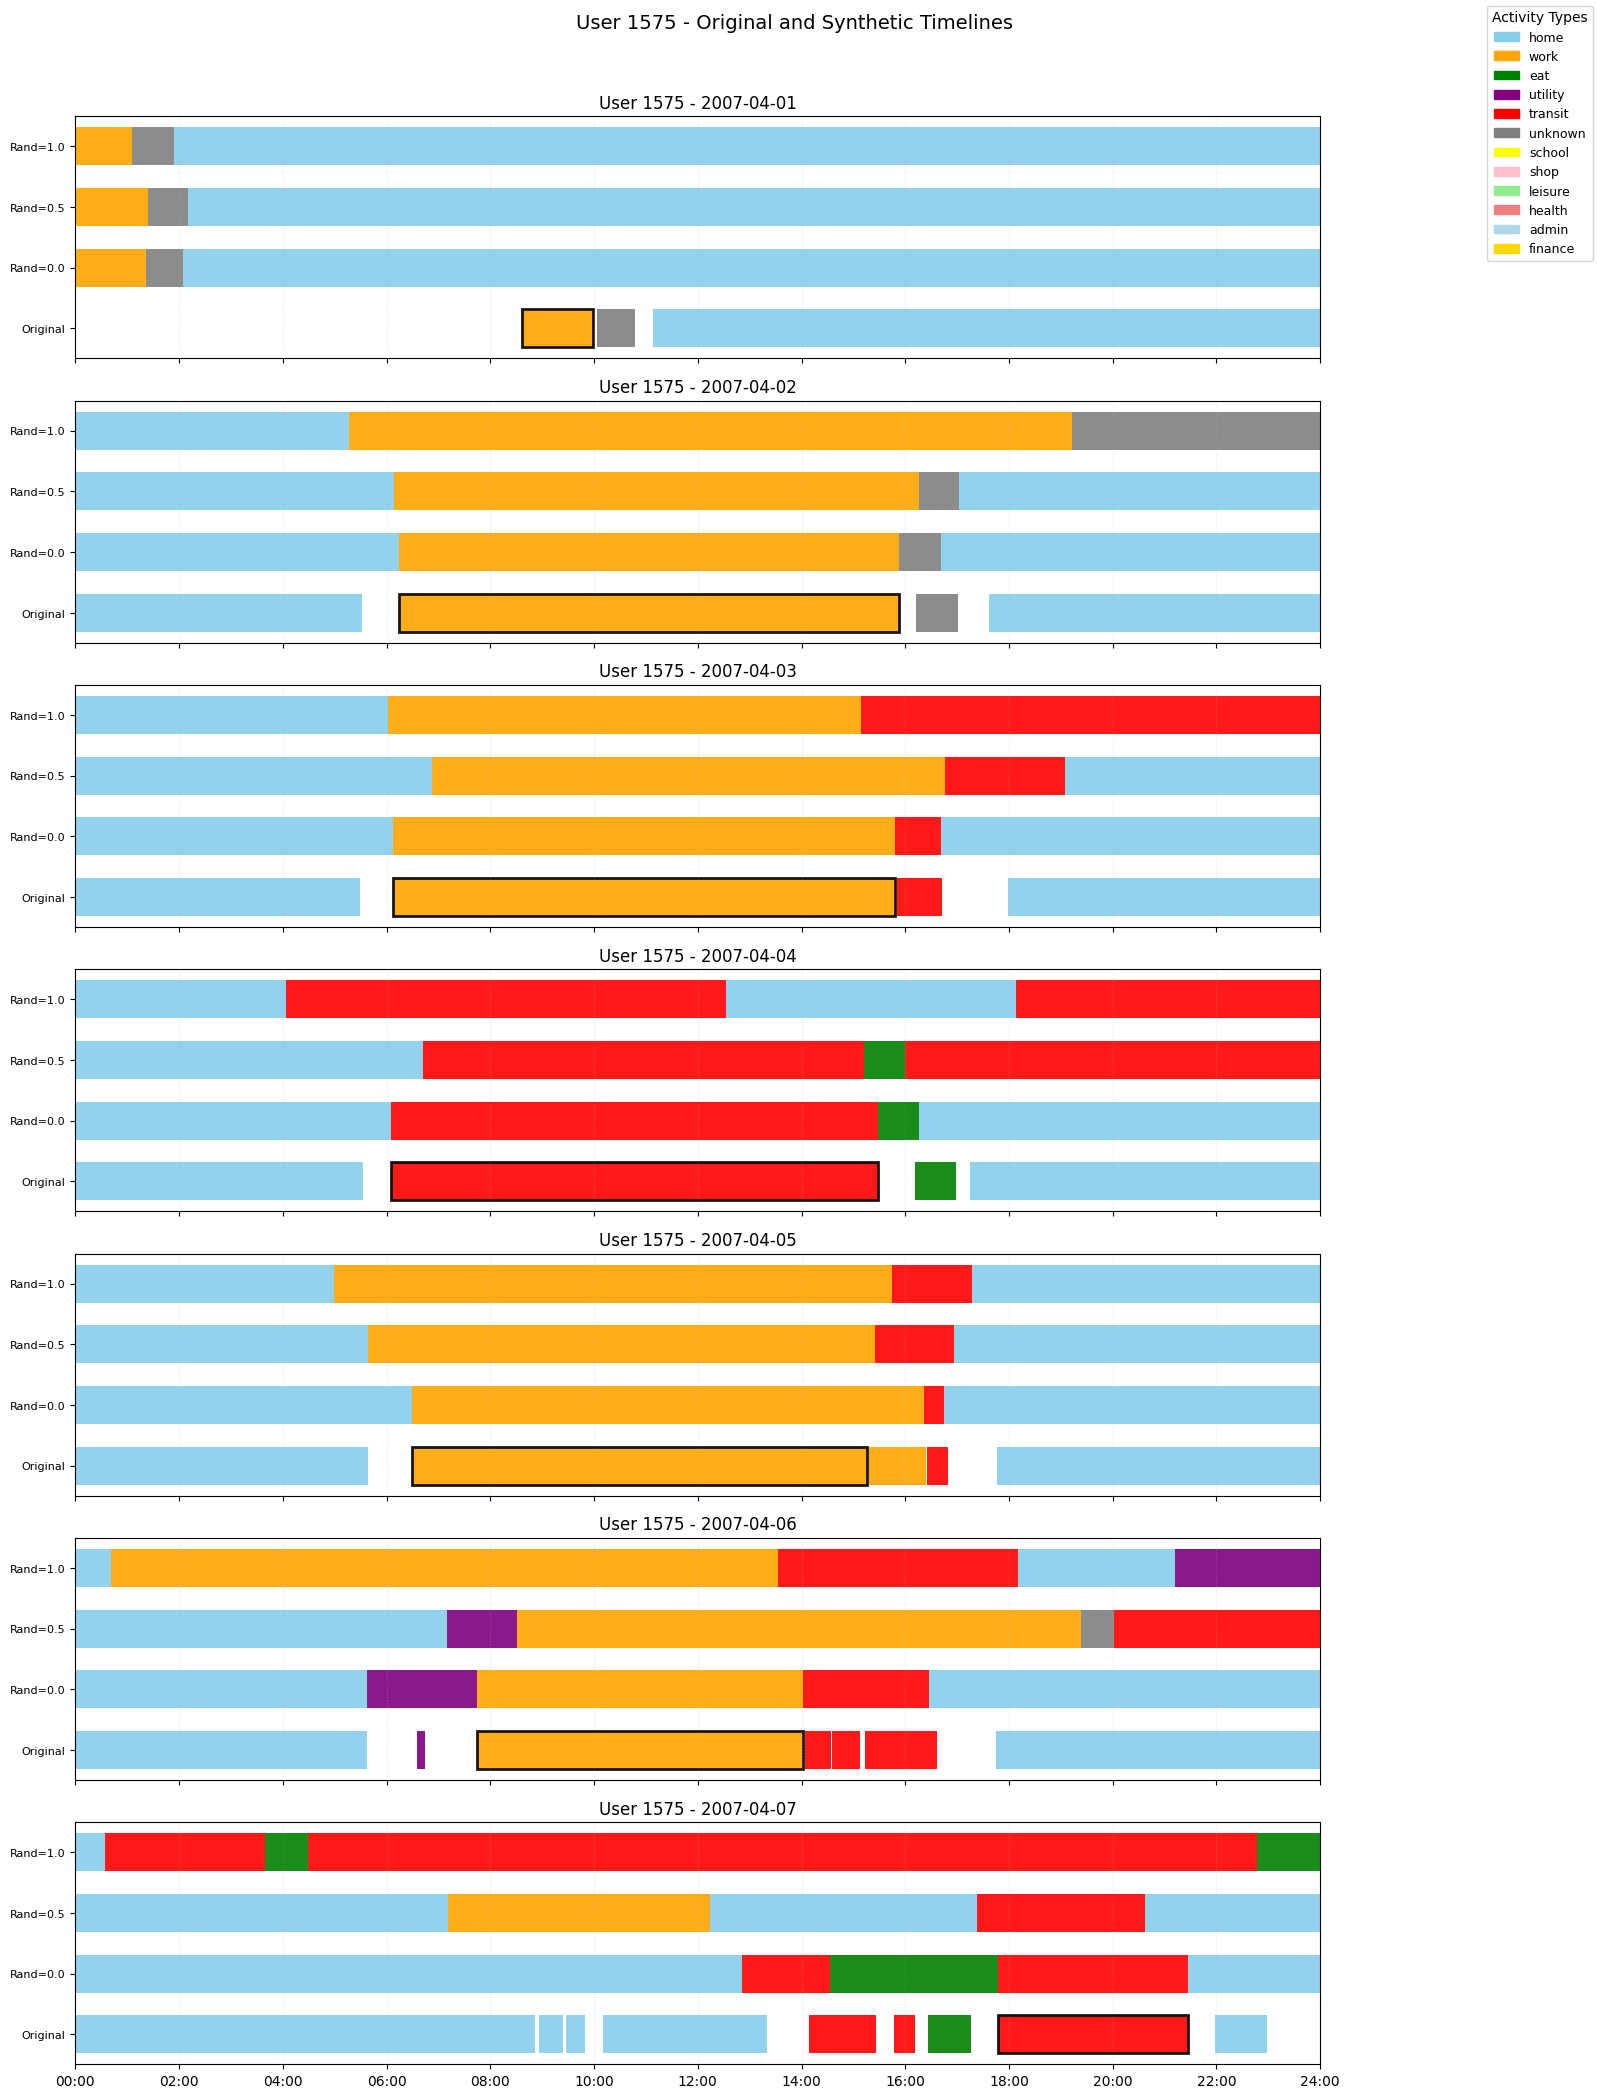

In [13]:
# --- Generate synthetic timelines for different randomness levels ---
randomness_levels = [0.0, 0.5, 1.0]
day_data = prepare_day_data(stays_by_day, user_duration_probs, user_transition_probs, randomness_levels, tz)

# --- Inspect one specific day for debugging ---
example_day = list(day_data.keys())[0]
print(f"Example day: {example_day}")
print(json.dumps(day_data[example_day], indent=2, default=str))

# --- Visualize original vs synthetic timelines for this user ---
fig = _visualize_day_data(day_data, user_id)
fig.show()

In [14]:
# This requires heavy resources (OSM graph, population raster).
# Skip if only testing timelines.
from src.spatial.resources import ensure_spatial_resources
from src.population.utils import generate_cumulative_map
from src.synthetic.spatial_sim import simulate_synthetic_trips

print("Preparing minimal spatial setup (may take a while)...")
G, gdf_cumulative_p, activity_pools = ensure_spatial_resources("data", generate_cumulative_map)
print("✓ Spatial resources ready")

chosen_r = 0.5
some_day = list(day_data.keys())[0]
synthetic_for_r = day_data[some_day]["synthetic"][chosen_r]

traj, osm_usage, pseudo_map_loc, rmse, legs_coords = simulate_synthetic_trips(
    enriched,
    synthetic_for_r,
    G,
    gdf_cumulative_p,
    randomness=chosen_r,
    activity_pools=activity_pools
)

print("Trajectory sample:", traj[:5])
print("Pseudo map sample:", list(pseudo_map_loc.items())[:5])
print("RMSE:", rmse)

Preparing minimal spatial setup (may take a while)...
  ✓ Loaded activity pools from cache
✓ Spatial resources ready
Trajectory sample: [(41.1794351, -8.5596469, 5075), (41.1793568, -8.5596248, np.float64(5075.71188738066)), (41.1792915, -8.5596907, np.float64(5076.441153472193)), (41.1792769, -8.5597054, np.float64(5076.604067182656)), (41.1790823, -8.5598519, np.float64(5078.593219996502))]
Pseudo map sample: [(0, 1904424011), (1, np.int64(12055130646)), (2, 2083726491)]
RMSE: 3.5613123700271023


In [25]:
from src.visualization.maps import (
    generate_interactive_porto_map_multi,
    create_split_map_html,
    generate_interactive_original_city_map
)
import os
import folium

# --- Visualize the synthetic spatial mapping ---
print("Visualizing single-user Porto trajectories...")

# Build the structure expected by generate_interactive_porto_map_multi
per_day_data = {
    "debug_day": {
        "trajectory": [(lat, lon, ts) for lat, lon, ts, *_ in traj],
        "legs_coords": legs_coords,
        "pseudo_map_loc": pseudo_map_loc,
        "synthetic_stays": synthetic_for_r
    }
}

# Define output paths
porto_map_path = os.path.join(paths.results_dir, f"user_{user_id}_porto_test_map.html")
orig_map_path = os.path.join(paths.results_dir, f"user_{user_id}_original_city_map.html")
split_map_path = os.path.join(paths.results_dir, f"user_{user_id}_split_debug.html")

# --- Generate the Porto synthetic map ---
generate_interactive_porto_map_multi(
    user_id=user_id,
    per_day_data=per_day_data,
    G=G,
    out_html_path=porto_map_path
)
print(f"✓ Porto map saved at: {porto_map_path}")

# --- Generate the original Milan map ---
print("Generating original city map for comparison...")
generate_interactive_original_city_map(
    user_id=user_id,
    enriched_imn=enriched,
    stays_by_day=stays_by_day,
    out_html_path=orig_map_path
)
print(f"✓ Original city map saved at: {orig_map_path}")

# --- Create split-view comparison map ---
create_split_map_html(
    left_src=orig_map_path,
    right_src=porto_map_path,
    left_title="Original (Milan)",
    right_title="Synthetic (Porto)",
    out_html_path=split_map_path
)
print(f"✓ Split-view map saved at: {split_map_path}")

Visualizing single-user Porto trajectories...
✓ Porto map saved at: ./debug_results/user_1575_porto_test_map.html
Generating original city map for comparison...
✓ Original city map saved at: ./debug_results/user_1575_original_city_map.html
✓ Split-view map saved at: ./debug_results/user_1575_split_debug.html
